In [1]:
#: the usual imports
import babypandas as bpd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

In [2]:
def plot_best_fit(table, x, y, margin=.02):
    m = slope(table, x, y)
    b = intercept(table, x, y)
    
    table.plot(kind='scatter', x=x, y=y)
    left = table.get(x).min()*(1 - margin)
    right = table.get(x).max()*(1 + margin)
    domain = np.linspace(left, right, 10)
    plt.plot(domain, m*domain + b, color='C1')

# Lecture 18

### Regression, Residuals, Inference

## Fill out your CAPEs!

# Regression

## Relationship between variables
* Association
    - any pattern or relationship between variables
* Correlation
    - a linear association
    - quantified by a nonzero correlation coefficient $r$
    
* Two variables may be linearly associated (i.e. correlated), but may not be *best* described by a linear association.

## The regression line

* The regression line describes the linear association present in data. 
* The regression line is given by $y = mx + b$, where:
    - the slope $m$ is: $$m = r\cdot\frac{SD\ of\ y}{SD\ of\ x}$$
    - the y-intercept $b$ is: $$b = (avg\ of\ y) - m\cdot(avg\ of\ x)$$


In [3]:
#:
def standard_units(arr):
    return (arr - arr.mean())/np.std(arr)

def correlation(t, x, y):
    return (standard_units(t.get(x))*standard_units(t.get(y))).mean()

def slope(t, x, y):
    """The slope of the regression line (original units)"""
    r = correlation(t, x, y)
    return r * np.std(t.get(y)) / np.std(t.get(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)"""
    return t.get(y).mean() - slope(t, x, y) * t.get(x).mean()


### Do people choose people of similar heights as mates?
 - "Are the heights of mothers/fathers linearly associated?"
 - Compute the correlation and regression line

0.060366119036644815

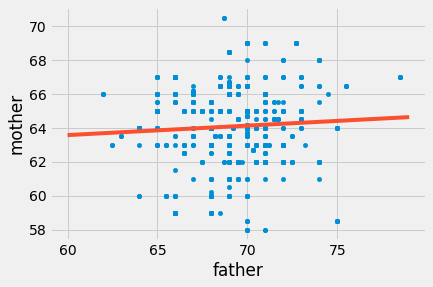

In [4]:
galton = bpd.read_csv('data/galton.csv')
m = slope(galton, 'father', 'mother')
b = intercept(galton, 'father', 'mother')

galton.plot(kind='scatter', x='father', y='mother')
x = np.arange(60, 80)
plt.plot(x, m*x+b, color='C1');

correlation(galton, 'mother', 'father')

## The effect of outliers on correlation
* What is the correlation coefficient of $x$ and $y$?

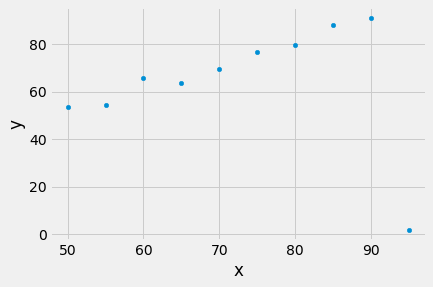

In [5]:
outlier = bpd.read_csv('data/outlier.csv')
outlier.plot(kind='scatter', x='x', y='y')

In [6]:
m = slope(outlier, 'x', 'y')
b = intercept(outlier, 'x', 'y')
correlation(outlier, 'x', 'y')

-0.02793982443854457

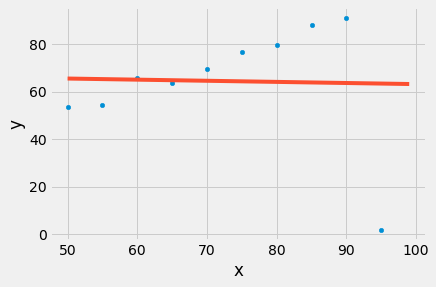

In [7]:
x = np.arange(50, 100)
outlier.plot(kind='scatter', x='x', y='y')
plt.plot(x, m*x+b, color='C1');

## Without the outlier

In [8]:
without_outlier = outlier[outlier.get('y') > 40]

In [9]:
m = slope(without_outlier, 'x', 'y')
b = intercept(without_outlier, 'x', 'y')
correlation(without_outlier, 'x', 'y')

0.9851437295364018

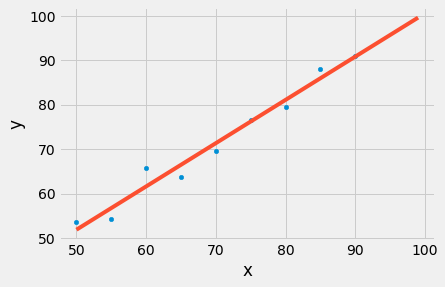

In [10]:
x = np.arange(50, 100)
without_outlier.plot(kind='scatter', x='x', y='y')
plt.plot(x, m*x+b, color='C1');

## Measuring the error in prediction

In [11]:
def plot_errors(m, b, t):
    x = t.get('x')
    y = m*x + b
    t.plot(kind='scatter', x='x', y='y')
    plt.plot(x, y)
    for k in np.arange(t.shape[0]):
        xk = t.get('x').iloc[k]
        yk = np.asarray(y)[k]
        plt.plot([xk, xk], [yk, t.get('y').iloc[k]], c='r', linewidth=2)
    
    plt.suptitle('y = %.2f * x + %.2f' %(m, b), fontsize=18)

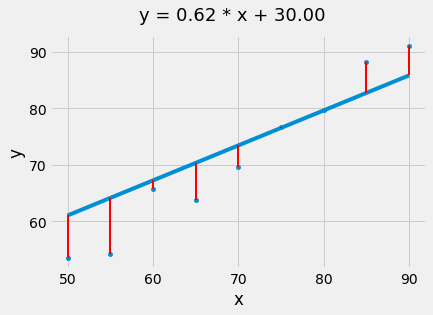

In [12]:
plot_errors(0.62, 30, without_outlier)

## Measuring the error in estimation

* error = actual value - prediction
* Typically, some errors are positive and some negative
    - What does a positive error mean? negative?

* To measure the rough size of the errors
    - square the errors to eliminate cancellation
    - take the mean of the squared errors
    - take the square root to fix the units
    - root mean square error (rmse)

## Calculate the root mean square error (RMSE)

In [13]:
preds = without_outlier.assign(pred=m * without_outlier.get('x') + b)
preds = preds.assign(diffs=preds.get('pred') - preds.get('y'))
preds = preds.assign(sq_diffs=preds.get('diffs')**2)
preds

,x,y,pred,diffs,sq_diffs
0,50,53.528797,51.838723,-1.690075,2.856352
1,55,54.205602,56.718362,2.512759,6.313958
2,60,65.654124,61.598000,-4.056124,16.452138
3,65,63.810015,66.477639,2.667624,7.116217
4,70,69.502517,71.357277,1.854761,3.440137
5,75,76.679051,76.236916,-0.442135,0.195483
6,80,79.609636,81.116554,1.506918,2.270803
7,85,88.172763,85.996193,-2.176570,4.737458
8,90,91.052990,90.875832,-0.177159,0.031385


In [14]:
np.sqrt(preds.get('sq_diffs').mean())

2.1963083164755397

## Calculate the root mean square error (RMSE)

In [15]:
def rmse(pred, true):
    '''calculate the RMSE of two arrays:
    pred: the array of predicted values
    true: the array of true values of the predicted attribute
    '''
    return np.sqrt(((pred - true)**2).mean())

## The error of linear predictors

* What is the best linear prediction function among all possible lines?
* Minimize the RMSE

In [16]:
def plot_errors_multi(m, b, t, ax):
    x = t.get('x')
    y = m*x + b
    ax.scatter(t.get('x'), t.get('y'))
    #t.scatter(0)
    ax.plot(x, y)
    for k in np.arange(t.shape[0]):
        xk = t.get('x').iloc[k]
        yk = y[k]
        ax.plot([xk, xk], [yk, t.get('y').iloc[k]], c='r', linewidth=2)
    
    error = rmse(y, t.get('y'))
    ax.set_title('y = %.2f * x + %.2f; rmse %f' %(m, b, error))
    

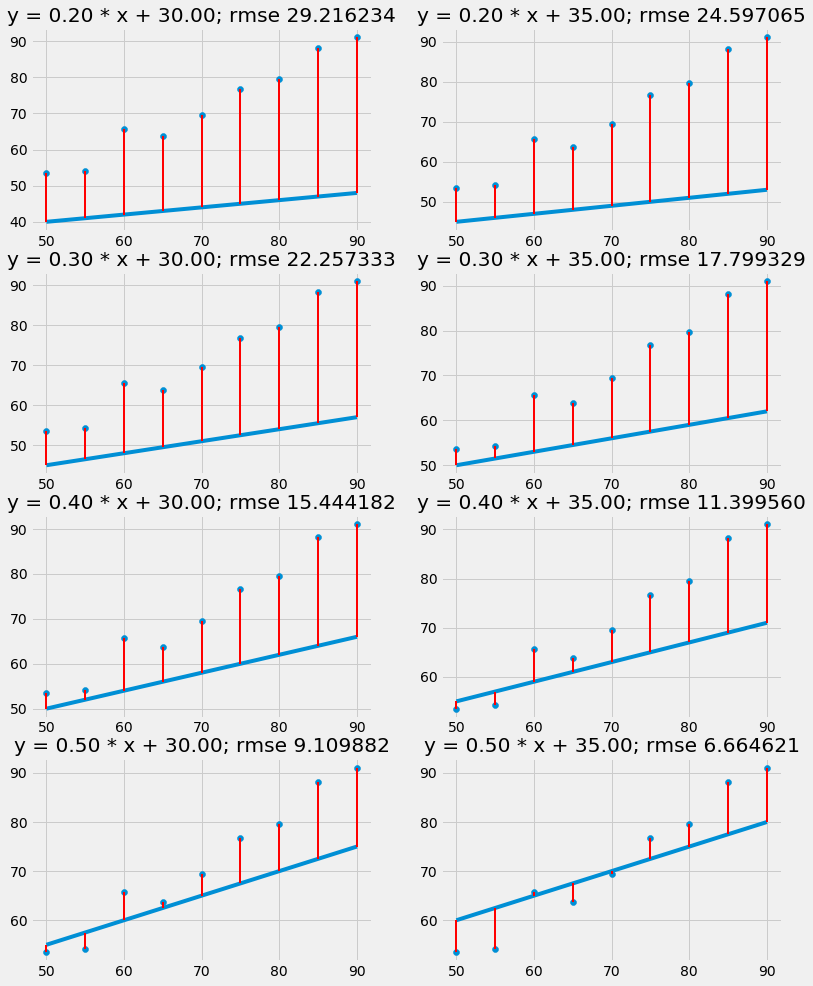

In [17]:
fig, axes = plt.subplots(4,2, figsize=(12,16))
k = 0
for m in np.arange(.2, .6, 0.1):
    for b in np.arange(30, 40, 5):
        plot_errors_multi(m, b, without_outlier, ax=axes[k//2, k % 2])
        k = k + 1

## Finding the best linear prediction function

Approach

1. Enumerate a large number of reasonable lines (i.e. pairs of slopes/intercepts)
2. Calculate the RMSE of each linear predictor
3. Take the slope/intercept pair with the smallest RMSE.

In [18]:
#:
errors = np.array([])
slopes = np.array([])
intercepts = np.array([])

for m in np.arange(-1, 1, 0.01):
    for b in np.arange(-50, 50, 0.5):
        pred = m * without_outlier.get('x') + b
        error = rmse(pred, without_outlier.get('y'))

        errors = np.append(errors, error)
        slopes = np.append(slopes, m)
        intercepts = np.append(intercepts, b)

In [19]:
# smallest
errors.min()

2.198056359119823

In [20]:
# smallest slope
m = slopes[errors.argmin()]
m

0.9700000000000017

In [21]:
# smallest intercept
b = intercepts[errors.argmin()]
b

3.5

In [22]:
# slope/intercept of the regression line
slope(without_outlier, 'x', 'y'), intercept(without_outlier, 'x', 'y')

(0.9759277157245881, 3.04233713529743)

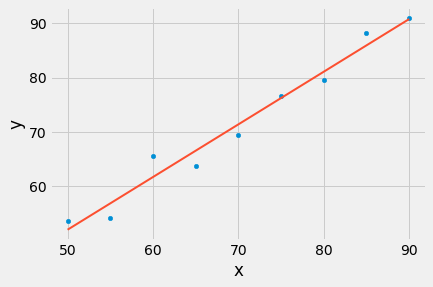

In [23]:
x = without_outlier.get('x')
without_outlier.plot(kind='scatter', x='x', y='y')
plt.plot(x, m*x + b, linewidth=2, color='C1')

## Least squares line

* Minimizes the root mean squared error (rmse) among all lines
* Coincides with the regression line!
    - Regression line defined using statistical quantities
    - Line of "best fit" defined using algebra/calculus
* All equivalent names:
    - Line of “best fit”
    - Least squares line
    - Regression line

## Regression line

* Describes the "best linear fit" of a given dataset.
* Describes the linear association of two attributes, given a the data are well described by a linear relationship!
* How do we know a linear fit is a good fit?

## Errors, pt II

Residuals

## Residuals

* Residuals are the errors in a regression estimate
* One residual corresponding to each point (x, y)
* residual = observed y - regression estimate of y 

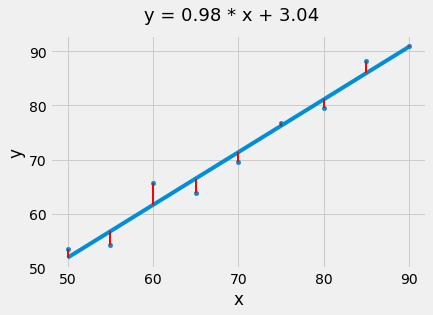

In [24]:
m = slope(without_outlier, 'x', 'y')
b = intercept(without_outlier, 'x', 'y')
plot_errors(m, b, without_outlier)

## Calculating residuals

In [25]:
def fit(t, x, y):
    m = slope(t, x, y)
    b = intercept(t, x, y)
    return m * t.get(x) + b

def residual(t, x, y):
    return t.get(y) - fit(t, x, y)

## Errors in prediction of child height

* Is "linear association" a good description of the relationship between parents and child?
    - is the (linear) association strong? (correlation coefficient)
    - is 'linear' the best description?

In [26]:
heights = bpd.DataFrame().assign(
    MidParent=galton.get('midparentHeight'),
    Child=galton.get('childHeight')
)

fitted = heights.assign(
    fit=fit(heights, 'MidParent', 'Child'),
    residuals=residual(heights, 'MidParent', 'Child')
)

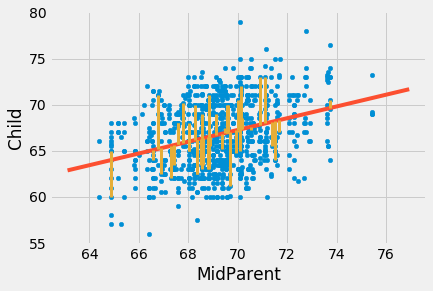

In [27]:
plot_best_fit(fitted, 'MidParent', 'Child')

idx = np.random.randint(0, fitted.shape[0], size=50)
for k in idx:
    x = fitted.get('MidParent').iloc[k]
    y = fitted.get('Child').iloc[k]
    p = fitted.get('fit').iloc[k]
    plt.plot([x,x], [y,p], linewidth=3, c='C2')

## The residual plot
* Scatterplot of the input variable (MidParent height) vs residuals
* Describes how the linear prediction error varies
    - patterns in the residual plot describe systematic errors in the linear fit!

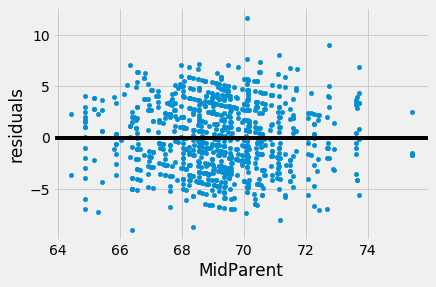

In [28]:
fitted.plot(kind='scatter', x='MidParent', y='residuals')
x = fitted.get('MidParent')
plt.axhline(0, color='k')

## Assessment of a linear fit for predicting child height
* Relatively small correlation coefficients suggest a weak association
    - many residuals have large magnitude.
    - predictions will have high variance.
* No pattern in residuals implies a linear model is reasonable
    - plot looks "blob-like".

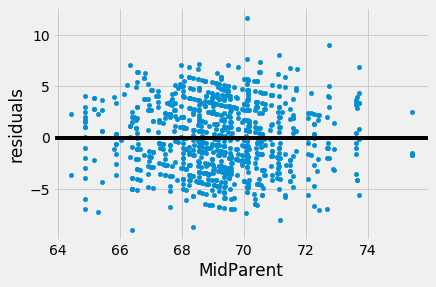

In [29]:
fitted.plot(kind='scatter', x='MidParent', y='residuals')
x = fitted.get('MidParent')
plt.axhline(0, color='k')

## Reading the residual plot

For good regressions, the residual plot:
* Should look like a blob
* About half above and half below the horizontal line at 0
* Similar vertical spread throughout
* No pattern

What are the implications for your predictions if these conditions aren't met?


## Residual plot of a non-linear association
* Hybrid car models: mpg vs msrp
* Where does the linear fit fail?

In [30]:
hybrid = bpd.read_csv('data/hybrid.csv')
hybrid_fitted = hybrid.assign(
    fit=fit(hybrid, 'mpg', 'msrp'),
    residuals=residual(hybrid, 'mpg', 'msrp')
)

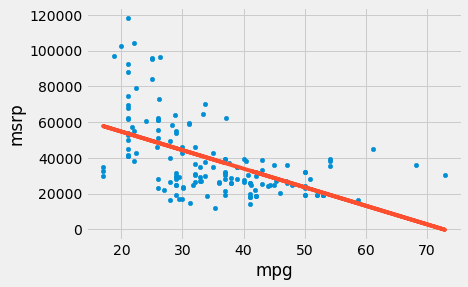

In [31]:
hybrid_fitted.plot(kind='scatter', x='mpg', y='msrp')
plt.plot(hybrid_fitted.get('mpg'), hybrid_fitted.get('fit'), color='C1');

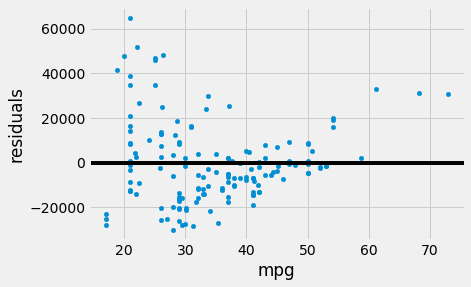

In [32]:
# plot residuals

hybrid_fitted.plot(kind='scatter', x='mpg', y='residuals')
plt.axhline(0, color='k')

## Dugong

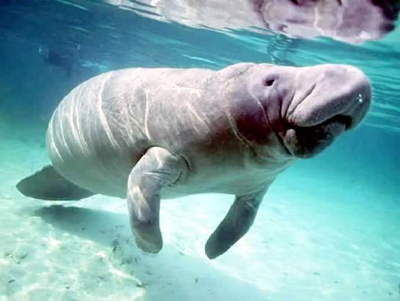

## Dugong

* Data: Size vs Age
* Can use these data to predict the age of an observed dugong of a given size?

In [33]:
dugong = bpd.read_csv('http://www.statsci.org/data/oz/dugongs.txt', delimiter='\t')
dugong

,Age,Length
0,1.0,1.80
1,1.5,1.85
2,1.5,1.87
3,1.5,1.77
4,2.5,2.02
...,...,...
22,16.5,2.64
23,17.0,2.56
24,22.5,2.70
25,29.0,2.72


In [34]:
dugong = dugong.assign(
    fit=fit(dugong, 'Length', 'Age'),
    residuals=residual(dugong, 'Length', 'Age')
)
dugong

,Age,Length,fit,residuals
0,1.0,1.80,-1.777806,2.777806
1,1.5,1.85,-0.589222,2.089222
2,1.5,1.87,-0.113788,1.613788
3,1.5,1.77,-2.490956,3.990956
4,2.5,2.02,3.451963,-0.951963
...,...,...,...,...
22,16.5,2.64,18.190404,-1.690404
23,17.0,2.56,16.288670,0.711330
24,22.5,2.70,19.616705,2.883295
25,29.0,2.72,20.092139,8.907861


## Is the association between age and length linear?
* No: scatterplot looks curved!
* The association is likely non-linear

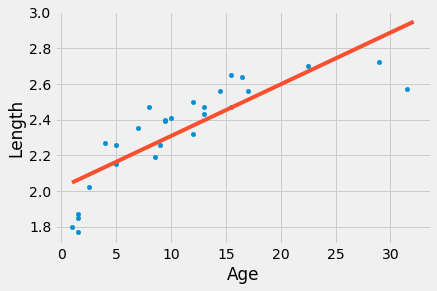

In [35]:
plot_best_fit(dugong, 'Age', 'Length')

## The residual plot for a non-linear association
* Patterns in where errors are positive vs negative
* Patterns in where the errors are larger/smaller
* How do these affect your predictions?

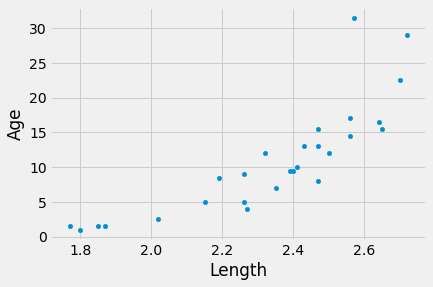

In [36]:
dugong.plot(kind='scatter', x='Length', y='Age')

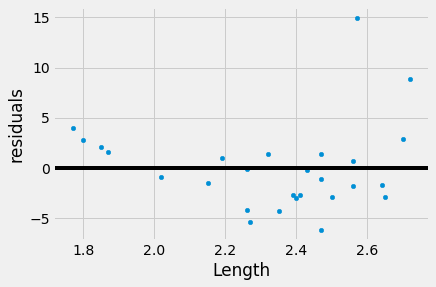

In [37]:
dugong.plot(kind='scatter', x='Length', y='residuals')
plt.axhline(0, color='k')

## Regression: mpg vs acceleration 
* Is the regression line a good predictor for acceleration, given mpg?
* Is the residual plot pattern-free?

In [38]:
accel_mpg = hybrid.assign(
    fit=fit(hybrid, 'acceleration', 'mpg'),
    residuals=residual(hybrid, 'acceleration', 'mpg')
)
accel_mpg

,vehicle,year,msrp,acceleration,mpg,class,fit,residuals
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact,43.293251,-2.033251
1,Tino,2000,35354.97,8.20,54.10,Compact,41.895697,12.204303
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact,42.330072,2.899928
3,Insight,2000,18936.41,9.52,53.00,Two Seater,39.402763,13.597237
4,Civic (1st Gen),2001,25833.38,7.04,47.04,Compact,44.086458,2.953542
...,...,...,...,...,...,...,...,...
148,S400,2013,92350.00,13.89,21.00,Large,31.149640,-10.149640
149,Prius Plug-in,2013,32000.00,9.17,50.00,Midsize,40.063768,9.936232
150,C-Max Energi Plug-in,2013,32950.00,11.76,43.00,Midsize,35.172329,7.827671
151,Fusion Energi Plug-in,2013,38700.00,11.76,43.00,Midsize,35.172329,7.827671


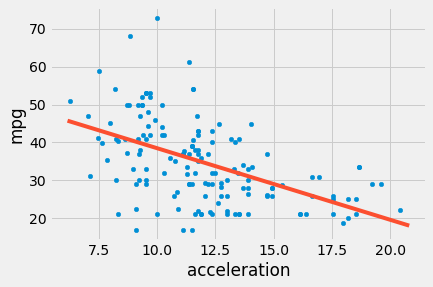

In [39]:
plot_best_fit(accel_mpg, 'acceleration', 'mpg')

In [40]:
correlation(accel_mpg, 'acceleration', 'mpg')

-0.5060703843771185

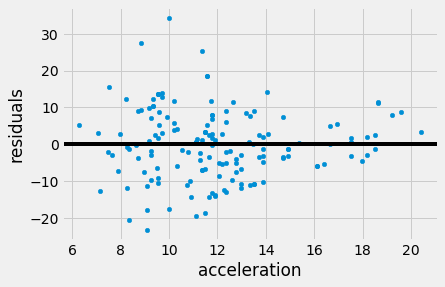

In [41]:
accel_mpg.plot(kind='scatter', x='acceleration', y='residuals')
plt.axhline(0, color='k')

## Heteroscedasticity

* Heteroscedasticity: "uneven" + "spread"
    
* Two attributes are heteroscedastic if there are subpopulations that have different variabilities
    - smaller errors as acceleration increases.
    
* Consequence: bias in the estimate of your errors of your predictions!

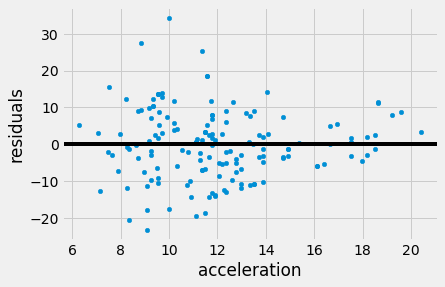

In [42]:
accel_mpg.plot(kind='scatter', x='acceleration', y='residuals')
plt.axhline(0, color='k')

### Discussion Question

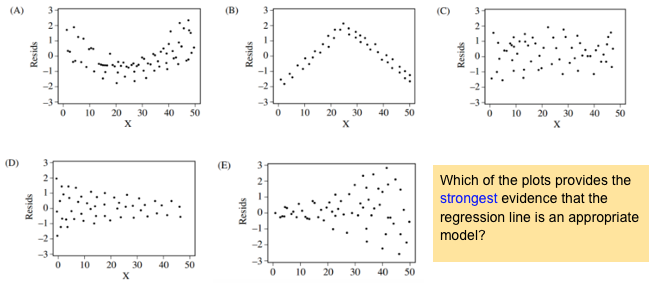

## Regression for prediction

What we're really doing:
* Collect data sample from population
* Fit regression line to sample
* Use regression line to predict values for new, out-of-sample data

What if we used a different sample?

## Prediction Intervals

Approach:
* Bootstrap the sample
* Generate a distribution of predictions
* Take e.g. the 95% confidence interval of the distribution of predictions

This will give an estimate of the variability of your predictions

### Regression model
* What model underlies the sample that we want to bootstrap?
* A linear regression model specifies that the data in a scatterplot is generated through a perfectly linear relationship, for which noise is added from a normal distribution of mean 0.
* A linear regression model:
    - is shaped like an oval, roughly around an "invisible" line,
    - has residuals that show no association

## Resampling the scatterplot: parent/child heights

(62, 77)

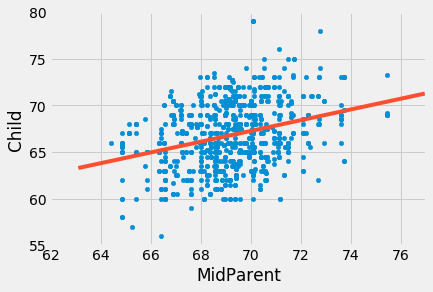

In [43]:
resampled = heights.sample(heights.shape[0], replace=True)
plot_best_fit(resampled, 'MidParent', 'Child')
plt.ylim([55, 80])
plt.xlim([62, 77])

## Bootstrapping Predictions: parent/child heights
* resample the scatterplot
* calculate the slope/intercept of the regression lines of the resamples
* calculate confidence intervals of a prediction using each line

In [44]:
m_orig = slope(heights, 'MidParent', 'Child')
b_orig = intercept(heights, 'MidParent', 'Child')

In [45]:
# bootstrap slope/intercept
boot_slopes = np.array([])
boot_intercepts = np.array([])

for _ in np.arange(5000):
    resample = heights.sample(heights.shape[0], replace=True)
    m = slope(resample, 'MidParent', 'Child')
    b = intercept(resample, 'MidParent', 'Child')
    boot_slopes = np.append(boot_slopes, m)
    boot_intercepts = np.append(boot_intercepts, b)

### If MidParent height is 74, what is the predicted child height?
* What reasonable variation in this prediction?
* What about 69 inches?

In [46]:
input_value = 74

In [47]:
pred = m_orig * input_value + b_orig
pred

69.80094692533117

In [48]:
boot_preds = boot_slopes * input_value + boot_intercepts

l = np.percentile(boot_preds, 2.5)
r = np.percentile(boot_preds, 97.5)
[l, r]

[69.20314534271665, 70.40578655764018]

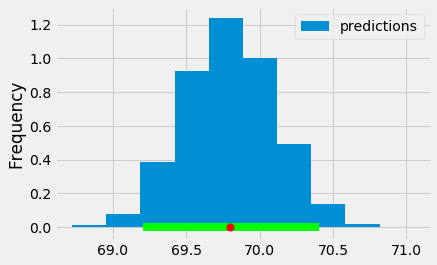

In [49]:
bpd.DataFrame().assign(
    predictions=boot_preds
).plot(kind='hist', density=True)
plt.scatter(pred, 0, c='r', linewidth=2, zorder=2)
plt.plot([l,r],[0,0], c='lime', linewidth=8, zorder=1);

### How do the prediction intervals vary with input?
* Plot all the regression lines!

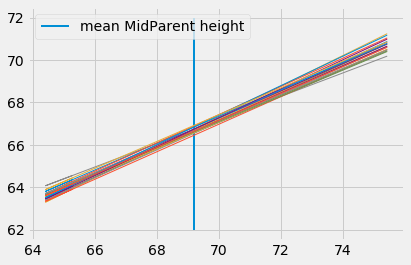

In [50]:
mean_mp = heights.get('MidParent').mean()
plt.plot([mean_mp, mean_mp], [62,72], linewidth=2);

ys = []
for (m,b) in zip(boot_slopes[:20], boot_intercepts):
    ys.append(m * x + b)
    plt.plot(x, m * x + b, linewidth=1)
    
plt.legend(['mean MidParent height'])

## 95% Confidence Interval

In [51]:
all_lines = np.vstack(ys)
upper = all_lines.max(axis=0)
lower = all_lines.min(axis=0)

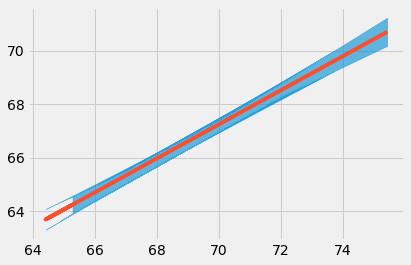

In [52]:
# heights.plot(kind='scatter', x='MidParent', y='Child', alpha=.1)
m = slope(heights, 'MidParent', 'Child')
b = intercept(heights, 'MidParent', 'Child')

plt.fill_between(x, upper, lower, alpha=.6, color='C0')
plt.plot(x, m*x + b, color='C1')